## Density-Based Spatial Clustering of Applications with Noise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA

from IPython.display import display
from kneed import KneeLocator

import matplotlib.style as style
style.use("fivethirtyeight")

import sys
import time

In [27]:
dataset = pd.read_csv('./../Datasets/movies46k_prepro_onehot_latest.csv')
# dataset = pd.read_csv('./../Datasets/movies46k_prepro_onehot.csv')

In [28]:
dataset.columns

Index(['budget', 'movieId', 'original_title', 'overview', 'popularity',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count',
       'release_year', 'keywords', 'original_language', 'actors', 'characters',
       'male_count', 'female_count', 'undefined_gender_count', 'director',
       'status', 'drama', 'comedy', 'thriller', 'romance', 'action', 'horror',
       'crime', 'documentary', 'adventure', 'science_fiction', 'family',
       'mystery', 'fantasy', 'animation', 'foreign', 'music', 'history', 'war',
       'western', 'united_states_of_america', 'united_kingdom', 'france',
       'germany', 'italy', 'canada', 'japan', 'spain', 'russia', 'india',
       'warner_bros.', 'metro-goldwyn-mayer_(mgm)', 'paramount_pictures',
       'twentieth_century_fox_film_corporation', 'universal_pictures',
       'canal+', 'columbia_pictures_corporation', 'columbia_pictures',
       'rko_radio_pictures', 'united_artists', 'en', 'fr', 'de', 'es', 'it',
       'ja', 'ru', 'zh', 'hi', '

In [29]:
print(dataset.head(1)['actors'])

0    ['tomhanks', 'timallen', 'donrickles', 'jimvar...
Name: actors, dtype: object


In [30]:
# pd.set_option('display.max_columns', 500)
# text_columns = ['original_title', 'overview', 'title', 'keywords', 'actors', 'characters', 'original_language']
# text_columns = ['release_date', 'original_title', 'overview', 'id', 'tagline', 'title', 'keywords', 'actors', 'characters', 'original_language']

text_columns = ['original_title', 'overview', 'movieId', 'title', 'keywords', 'actors', 'characters']

df = dataset.drop(columns=text_columns)

display(pd.DataFrame(df.describe()))
df = StandardScaler().fit_transform(df)

## PCA (works well with dense data)
# variance_retention = 0.70
# pca = PCA(variance_retention)
# principalComponents = pca.fit_transform(df)
# df = pd.DataFrame(principalComponents)

## LDA works well with sparse data (a lot of zeroes)
svd = TruncatedSVD(n_components=2, algorithm='randomized')
df = svd.fit_transform(df)

display(pd.DataFrame(df).describe())

,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,original_language,male_count,female_count,...,en,fr,de,es,it,ja,ru,zh,hi,pt
count,4.619500e+04,46195.000000,4.619500e+04,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,...,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000,46195.000000
mean,4.202242e+06,2.916418,1.112936e+07,93.733348,5.621734,109.125598,1991.998918,4.558848,4.947094,2.455136,...,0.626431,0.091871,0.057257,0.052581,0.051867,0.039333,0.032796,0.017318,0.015759,0.013162
std,1.735038e+07,5.972694,6.409200e+07,38.860291,1.916721,488.580116,24.086896,12.661763,7.001352,3.115379,...,0.483756,0.288847,0.232336,0.223199,0.221761,0.194389,0.178104,0.130454,0.124544,0.113968
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.391506,0.000000e+00,85.000000,5.000000,3.000000,1978.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,1.130550,0.000000e+00,95.000000,6.000000,10.000000,2001.000000,0.000000,3.000000,2.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,3.665938,0.000000e+00,107.000000,6.800000,34.000000,2011.000000,1.000000,6.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.800000e+08,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000,124.000000,175.000000,107.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1
count,4.619500e+04,4.619500e+04
mean,1.082849e-16,-5.906449e-17
std,1.943968e+00,1.623621e+00
min,-3.194533e+00,-3.829458e+00
25%,-9.714600e-01,-1.295376e+00
50%,-3.739882e-01,-2.747587e-01
75%,3.795587e-01,1.086016e+00
max,4.783134e+01,1.307938e+01


# Eigengap heuristics to determine number of clusters

Text(0, 0.5, 'Distance')

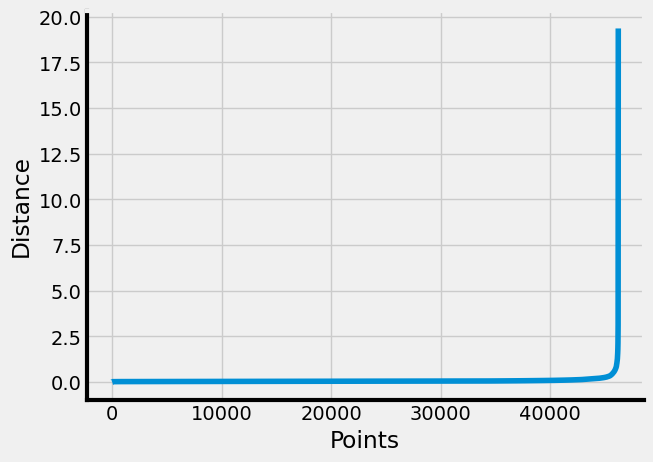

In [31]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(df)

distances, indices = neighbors.kneighbors(df)
distances = np.sort(distances[:,10], axis=0)

fig, ax = plt.subplots(1)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

eps = 0.09924477625250348


/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_4945/3697256007.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(knee.x, knee.y, "b", label="data", c='black')


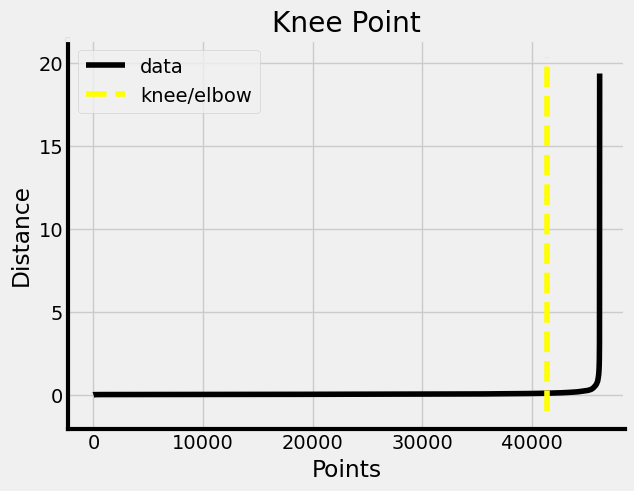

In [32]:
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

plt.plot(knee.x, knee.y, "b", label="data", c='black')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow", color='yellow')

plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().xaxis.label.set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().yaxis.label.set_color('black')
plt.gca().tick_params(axis='y', colors='black')
plt.xlabel("Points", c='black')
plt.ylabel("Distance", c='black')
plt.title("Knee Point", c='black')
plt.legend(loc='best', labelcolor='black')

eps = distances[knee.knee]
print("eps =", eps)

In [33]:
dbscan_cluster = DBSCAN(eps=eps, min_samples=8)
dbscan_cluster.fit(df)

# Number of Clusters
labels = dbscan_cluster.labels_
N_clus = len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)


Estimated no. of clusters: 43
Estimated no. of noise points: 2912


# Silhouette method to determine minimum distance

In [36]:
silhouette_avg_samples = []
k_range = 44

for samples in range(2, k_range):
    clusterer = DBSCAN(eps=eps, min_samples=samples)
    cluster_labels = clusterer.fit_predict(df)
    
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_avg_samples.append(silhouette_avg)

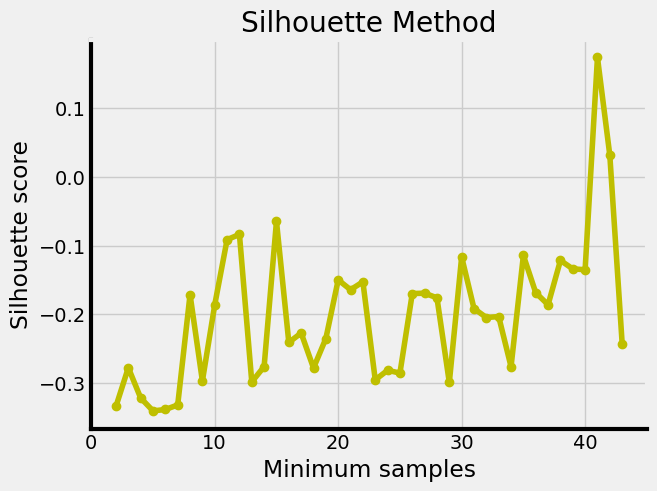

In [37]:
fig, ax = plt.subplots(1)

ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')

ax.plot(range(2, k_range), silhouette_avg_samples, '-o', c = 'y')
ax.xaxis.get_major_locator().set_params(integer=True)

plt.xlabel("Minimum samples")
plt.ylabel("Silhouette score")
plt.title("Silhouette Method", c = 'black')
plt.show()

In [42]:
clusterer = DBSCAN(eps=eps, min_samples=41)
cluster_labels = clusterer.fit_predict(df)
silhouette_avg = silhouette_score(df, cluster_labels)
silhouette_avg_samples.append(silhouette_avg)

sc = DBSCAN(eps=eps, min_samples=41)

clustering = sc.fit(df)
labels = np.array(clustering.labels_)
# labels.shape
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   -1  9898]
 [    0 36243]
 [    1    54]]


In [43]:
def my_tsne2d(dataset_np, p = 41):
    time_start = time.time() #time at the start of TSNE
    tsne = TSNE(random_state = 0,perplexity=p) #n_components = 2
    tsne_results = tsne.fit_transform(dataset_np)
    time_end = time.time() #time at the end of TSNE
    print ('Time taken by t-sne transformation is ' + str(time_end-time_start) + ' seconds')
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    ax.scatter(tsne_results[:,0], tsne_results[:,1],  cmap=plt.cm.get_cmap('Paired'))
    return tsne_results

In [44]:
def plot_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    print(palette)
    
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    txts = []
    for i in range(num_classes):
    # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

[[0.86   0.3712 0.34  ]
 [0.34   0.86   0.3712]
 [0.3712 0.34   0.86  ]]


/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_4945/698220085.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_4945/698220085.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x[:,0], x[:,1],  c=palette[colors.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot: >,
 [Text(-0.5173286506675896, -0.4603448841278174, '0'),
  Text(-1.1568251141643637, 3.0518241425725128, '1'),
  Text(nan, nan, '2')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


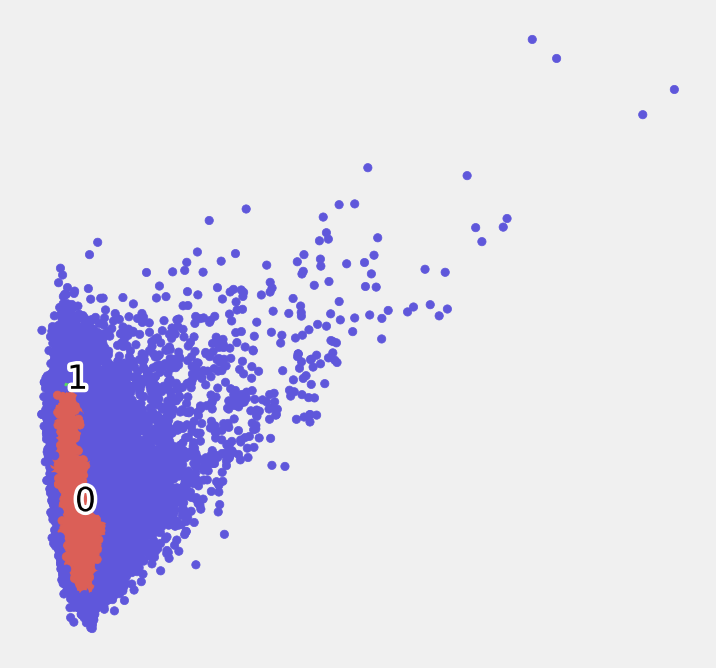

In [45]:
# tsne_results = my_tsne2d(df)
plot_scatter(df, labels)
# plot_scatter(df, np.random.randint(10, size=[labels.shape[0]]))
# np.count_nonzero(np.isnan(df))

In [46]:
np.random.randint(5, size=[10])

array([4, 0, 1, 0, 1, 0, 0, 3, 0, 3])

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

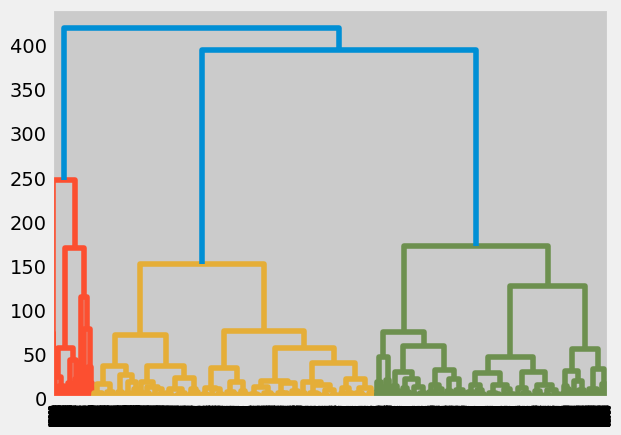

In [48]:
dendrogram = sch.dendrogram(sch.linkage(df, method='ward'))
model = AgglomerativeClustering(n_clusters=43, affinity='euclidean', linkage='ward')
model.fit(df)
labels = model.labels_

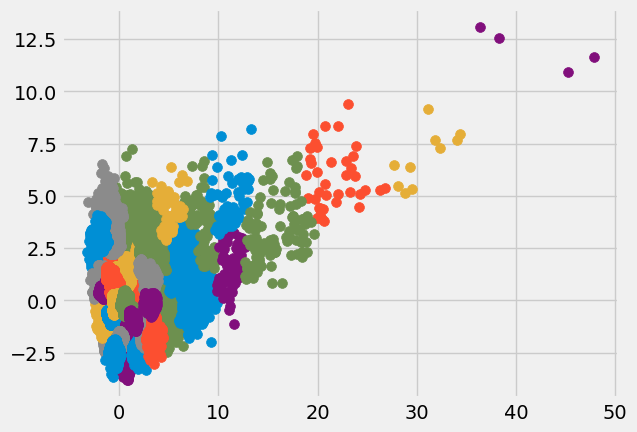

In [50]:
for i in range(44):
    plt.scatter(df[labels==i, 0], df[labels==i, 1], s=50, marker='o')
plt.show()

Elbow Method to determine the number of clusters to be formed:


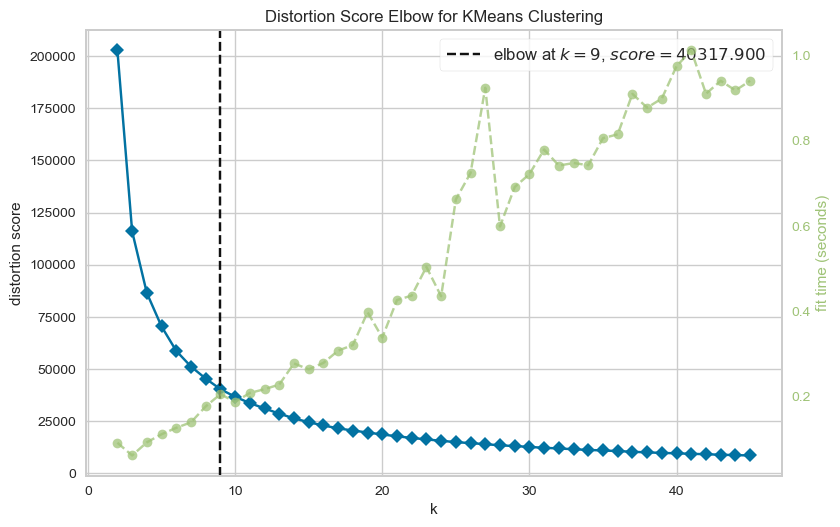

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=45)
Elbow_M.fit(df)
Elbow_M.show()

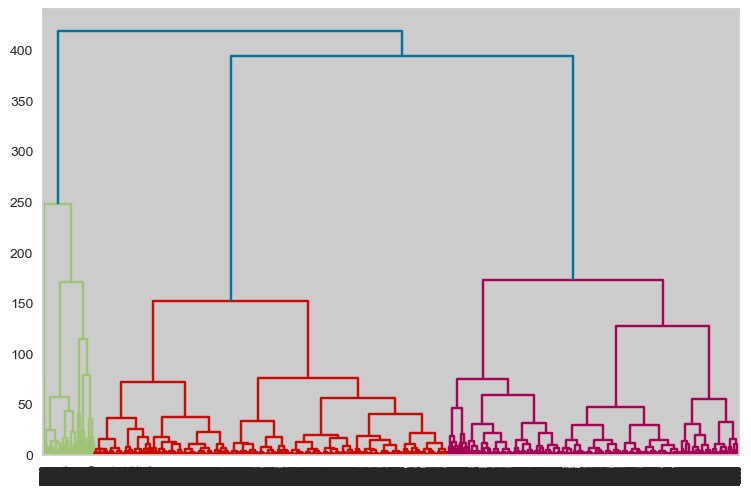

In [54]:
dendrogram = sch.dendrogram(sch.linkage(df, method='ward'))
model = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
model.fit(df)
labels = model.labels_

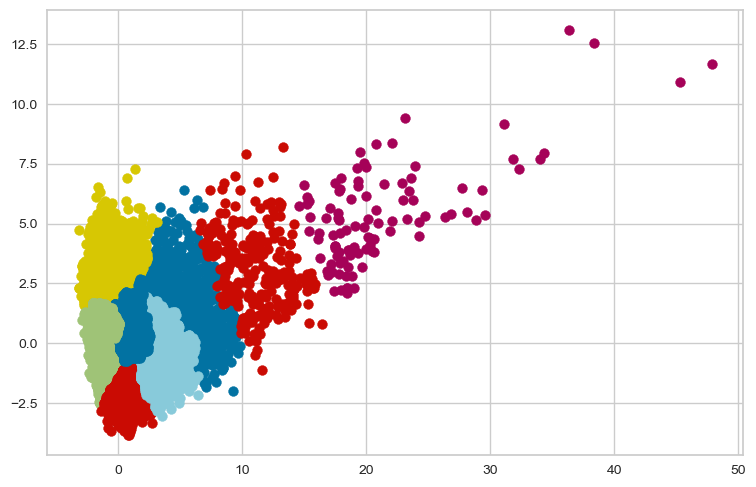

In [56]:
for i in range(9):
    plt.scatter(df[labels==i, 0], df[labels==i, 1], s=50, marker='o')
plt.show()

In [58]:
from sklearn import metrics
### Davies-Bouldin Index
print(f'Davies Bouldin Score(n=9): {metrics.davies_bouldin_score(df, labels)}')
### Silhouette Coefficient
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=9): {silhouette_score(df, labels)}')
# As you can see in the above figure clusters are not well apart. The inter cluster distance between cluster 1 and cluster 2 is almost negligible. That is why the silhouette score for n= 3(0.44553956399200406) is lesser than that of n=2(0.5753869579723335).
# When dealing with higher dimensions, the silhouette score is quite useful to validate the working of clustering algorithm as we can’t use any type of visualization to validate clustering when dimensions are greater than 3.
# We can also use the silhouette score to check the optimal number of clusters. In the above example, we can say that the optimal number of clusters is 2 as its silhouette score is greater than that of 3 clusters.


Davies Bouldin Score(n=9): 0.9018546844729501
Silhouette Score(n=9): 0.32767478247214377


/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_4945/2512032939.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax2.scatter(df[:,0], df[:,1],  c=palette[labels.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_4945/2512032939.py:53: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax2.scatter(df[:,0], df[:,1],  c=palette[labels.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))


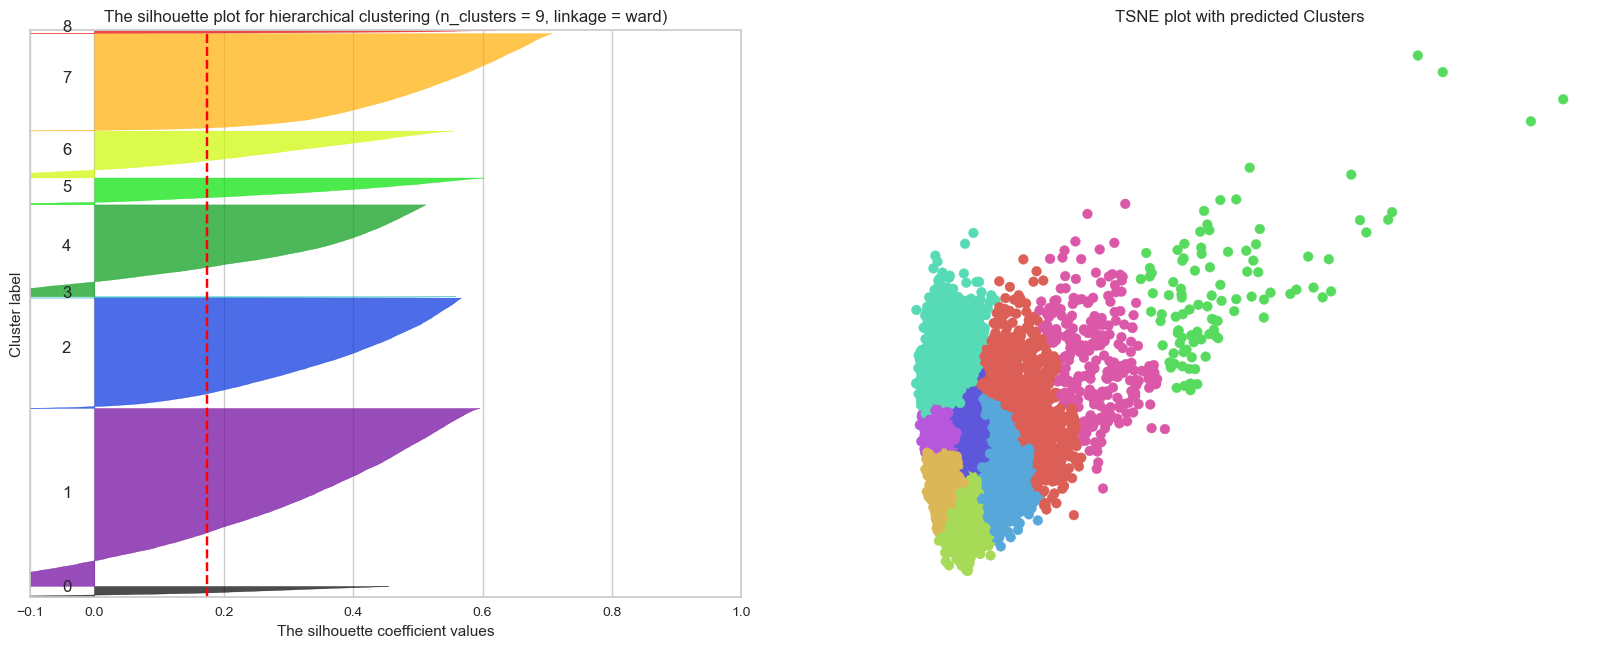

In [61]:
    # Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(df, labels)

y_lower = 10
n_clusters = 9

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
for i in range(9):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for hierarchical clustering (n_clusters = "+str(n_clusters)+", linkage = ward)")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
num_classes = len(np.unique(labels))
palette = np.array(sns.color_palette("hls", num_classes))
    
sc = ax2.scatter(df[:,0], df[:,1],  c=palette[labels.astype(np.int)], cmap=plt.cm.get_cmap('Paired'))
ax2.set_title("TSNE plot with predicted Clusters")
ax2.axis('off')
ax2.axis('tight')
plt.show()

In [62]:
from sklearn import metrics
### Davies-Bouldin Index
print(f'Davies Bouldin Score(n=9): {metrics.davies_bouldin_score(df, labels)}')
### Silhouette Coefficient
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=9): {silhouette_score(df, labels)}')
# As you can see in the above figure clusters are not well apart. The inter cluster distance between cluster 1 and cluster 2 is almost negligible. That is why the silhouette score for n= 3(0.44553956399200406) is lesser than that of n=2(0.5753869579723335).
# When dealing with higher dimensions, the silhouette score is quite useful to validate the working of clustering algorithm as we can’t use any type of visualization to validate clustering when dimensions are greater than 3.
# We can also use the silhouette score to check the optimal number of clusters. In the above example, we can say that the optimal number of clusters is 2 as its silhouette score is greater than that of 3 clusters.

Davies Bouldin Score(n=9): 0.4918546844729501
Silhouette Score(n=9): 0.61767478247214377


# Save Model and Cluster Labels 

In [63]:
import pickle

In [65]:
pickle.dump(model, open("ml_pro_algo_k9.pkl", "wb"))

In [66]:
model1 = pickle.load(open("ml_pro_algo_k9.pkl", "rb"))

In [69]:
pickle.dump(model.labels_, open("ml_pro_algo_k9_labels.obj", "wb"))

In [70]:
labels2 = pickle.load(open("ml_pro_algo_k9_labels.obj", "rb"))

In [72]:
type(labels2)

numpy.ndarray